In [1]:
import pymongo
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["app"]
mycol = mydb["twitter_raw"]
mycol2 = mydb["clf_twitter"]

In [3]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
today_but_last_week = (datetime.datetime.now() - datetime.timedelta(days=7)).strftime('%Y-%m-%d')

def get_cve_topk(startdate=today_but_last_week, enddate=today, topk=3):
    cve = {}
    startdate = datetime.datetime.strptime(startdate, '%Y-%m-%d')
    enddate = datetime.datetime.strptime(enddate, '%Y-%m-%d')
    numdays = (enddate - startdate).days
    for x in mycol.find({"content": {"$regex": ".*cve.*"}}):
        if startdate <= x['date'] <= enddate:
            words = x['content'].split()
            for word in words:
                if word.startswith('cve'):
                    word = word.lower().replace(':', '').replace(',', '').replace('.', '').replace(';', '').replace(')', '').replace('(', '')
                    cve[word] = cve.get(word, 0) + 1
    sorted_cve = sorted(cve.items(), key=lambda x: x[1], reverse=True)
    topk = sorted_cve[:topk]
    topk_cve = [x[0] for x in topk]
    return cve, topk_cve

cve, topk_cve = get_cve_topk()
print(topk_cve)

['cve-2022-42889', 'cve-2022-40684', 'cve-2022-37969']


In [4]:
def get_content_dt(field, word, startdate, enddate):
    content = []
    startdate = datetime.datetime.strptime(startdate, '%Y-%m-%d')
    enddate = datetime.datetime.strptime(enddate, '%Y-%m-%d')
    numdays = (enddate - startdate).days
    for x in mycol.find({field: {'$regex': '.*'+word+'.*', '$options': 'i'}}):
        if startdate <= x['date'] <= enddate:
            content.append(x)
    
    freq_val = []
    for day in range(numdays):
        day = startdate + datetime.timedelta(days=day)
        freq_val.append(len([x for x in content if x['date'].date() == day.date()]))
    
    freq = dict(zip([startdate + datetime.timedelta(days=x) for x in range(numdays)], freq_val))
    return content, freq

In [5]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
today_but_last_week = (datetime.datetime.now() - datetime.timedelta(days=7)).strftime('%Y-%m-%d')

In [6]:
query, freq = get_content_dt('content', 'cve-2022-37969', today_but_last_week, today)

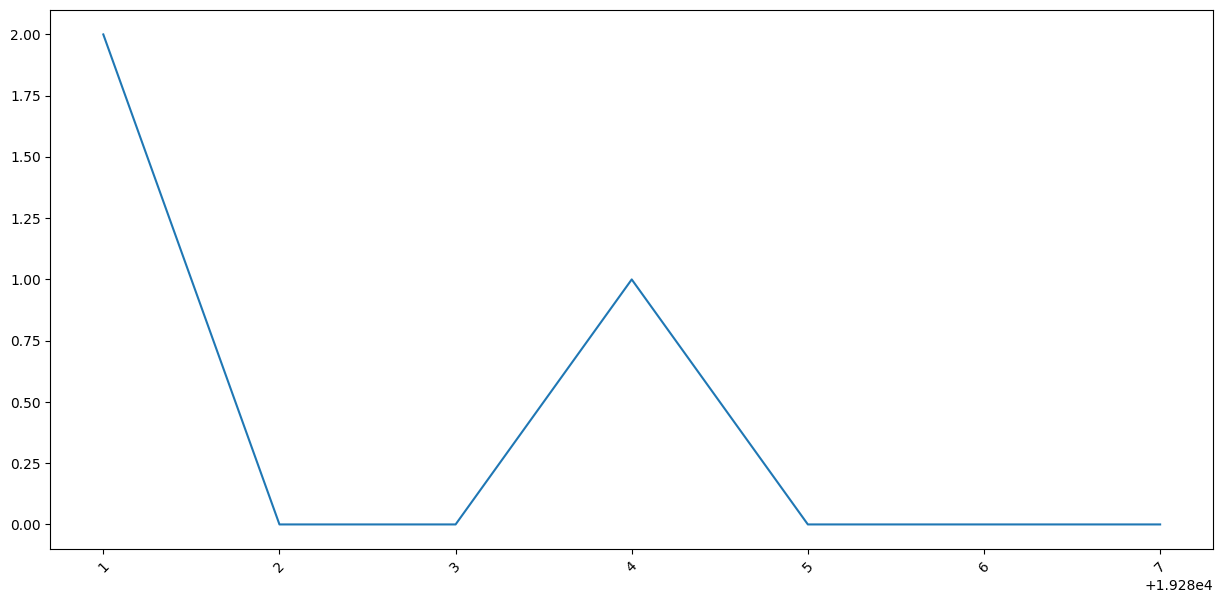

In [7]:
# Plot the data
xtick_list = [datetime.datetime.strptime(today_but_last_week, '%Y-%m-%d') + datetime.timedelta(days=x) for x in range(0, 30)]
fig, ax = plt.subplots(figsize=(15, 7))
# config y axis as integer
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(xtick_list, rotation=45)
ax.plot(list(freq.keys()), list(freq.values()), color='tab:blue')

In [8]:
def get_content(field, word, enddate=datetime.datetime.now().strftime('%Y-%m-%d'), 
                                startdate=(datetime.datetime.now() - datetime.timedelta(days=7)).strftime('%Y-%m-%d')):

    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["app"]
    mycol = mydb["twitter_raw"]

    content = []

    numdays = (enddate - startdate).days
    for x in mycol.find({field: {'$regex': '.*'+word+'.*', '$options': 'i'}}):
        if startdate <= x['date'] <= enddate:
            content.append(x)

    # find the day with the most tweets containing the word
    
    
    freq_val = []
    for day in range(numdays):
        day = startdate + datetime.timedelta(days=day)
        freq_val.append(len([x for x in content if x['date'].date() == day.date()]))
    
    freq_week = dict(zip([startdate + datetime.timedelta(days=x) for x in range(numdays)], freq_val))

    df = pd.DataFrame(freq.items(), columns=['date', 'freq'])
    
    return df

In [25]:
# def get_content_hour(field, word, yesterday=datetime.datetime.now().strftime('%Y-%m-%d'),
#     content = []
#     for x in mycol.find({field: {'$regex': '.*'+word+'.*', '$options': 'i'}}):
#         if date == x['date'].date():
#             content.append(x)
    
#     freq_val = []
#     for hour in range(24):
#         freq_val.append(len([x for x in content if x['date'].hour == hour]))
    
#     freq = dict(zip([datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(hours=x) for x in range(24)], freq_val))
    
#     df = pd.DataFrame(freq.items(), columns=['date', 'freq'])
    
#     return df

In [9]:
from wordcloud import WordCloud, STOPWORDS

In [10]:
def get_random(year, num):
    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["app"]
    mycol = mydb["twitter_raw"]
    mycol2 = mydb["clf_twitter"]

    # get id from clf_twitter that predicted as 1
    id_list = [x['id'] for x in mycol2.find({'prediction': "1"}).limit(num)]

    # get random tweets from twitter_raw
    random_tweets = []
    for id in id_list:
        random_tweets.append(mycol.find_one({'id': id}))

    return random_tweets

In [11]:
record_content = [x['content'] for x in get_random(2022, 1000)]

In [12]:
# Generate a word cloud image
def generate_wordcloud(text_list):
    text = ' '.join(text_list)
    wordcloud = WordCloud(background_color='white',
                          width=2200,
                          height=2000,
                          include_numbers=True,
                         ).generate(text)
    return wordcloud


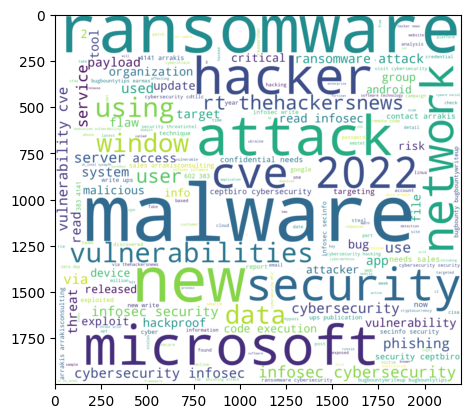

In [13]:
# display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(generate_wordcloud(record_content), interpolation='bilinear')

In [14]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
today_but_last_week = (datetime.datetime.now() - datetime.timedelta(days=10000)).strftime('%Y-%m-%d')

def get_cve(startdate=today_but_last_week, enddate=today, topk=3):
    cve = []
    startdate = datetime.datetime.strptime(startdate, '%Y-%m-%d')
    enddate = datetime.datetime.strptime(enddate, '%Y-%m-%d')
    numdays = (enddate - startdate).days
    for x in mycol.find({"content": {"$regex": ".*cve.*"}}):
        if startdate <= x['date'] <= enddate:
            words = x['content'].split()
            for word in words:
                if word.startswith('cve'):
                    word = word.lower().replace(':', '').replace(',', '').replace('.', '') \
                                        .replace(';', '').replace(')', '').replace('(', '').replace('!', '').replace(']', '').replace('-', '')
                    if len(word) < 8:
                        continue
                    cve.append(word)
    return cve

cve_list = get_cve()

In [15]:
import matplotlib.pyplot as plt
# import image
from PIL import Image

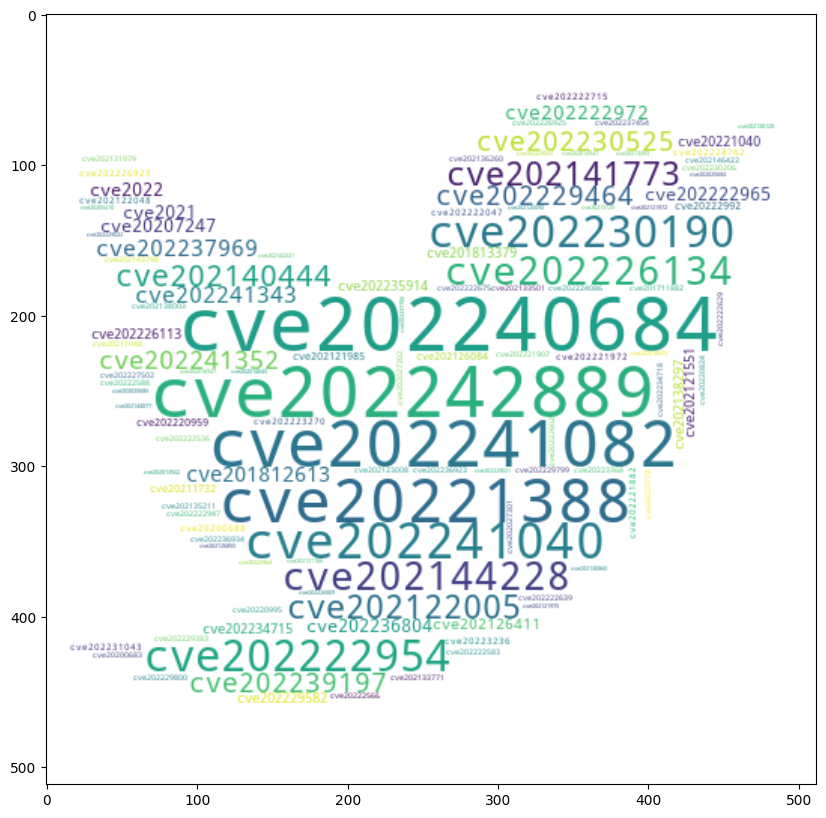

In [16]:
# create mask for wordcloud from image
image = 'twitterlogo.png'
mask = np.array(Image.open(image))

# create wordcloud
wc = WordCloud(background_color="white", max_words=2000, mask=mask, collocations=False)
wc.generate(' '.join(cve_list))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')    

In [18]:
wc.to_file('twitter_wordcloud.png')

In [51]:
def get_random_blog(year, num):
    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["app"]
    mycol = mydb["blog_raw"]
    mycol2 = mydb["clf_blog"]

    # get id from clf_twitter that predicted as 1
    id_list = [x['id'] for x in mycol.find({"content": {"$regex": ".*cve.*"}}).limit(num)]

    # get random tweets from twitter_raw
    random_blog = []
    for id in id_list:
        random_blog.append(mycol.find_one({'id': id}))

    return random_blog

In [50]:
import json
import kafka
import pymongo
import logging
from transformers import pipeline
from transformers import BartTokenizer, PegasusTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from transformers import BartForConditionalGeneration, PegasusForConditionalGeneration

import warnings
warnings.filterwarnings("ignore")

MAX_LENGTH = 512

model = BartForConditionalGeneration.from_pretrained('Yale-LILY/brio-cnndm-uncased')
tokenizer = BartTokenizer.from_pretrained('Yale-LILY/brio-cnndm-uncased')

client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client['app']
collection = db['sum_blog']

def summary(data):
    inputs = tokenizer([data['content']], max_length=MAX_LENGTH, return_tensors="pt", truncation=True,padding="longest")
    summary_ids = model.generate(inputs['input_ids'], num_beams=2, min_length=30, max_length=128)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    record  = {
        'id': data['id'],
        'summary': summary,
    }
    collection.insert_one(record)


In [55]:
from tqdm import tqdm

random_blog = get_random_blog(2022, 100)

for data in tqdm(random_blog):
    summary(data)

100%|██████████| 77/77 [07:38<00:00,  5.96s/it]


In [56]:
def get_sum_blog(year="2022", num=100):
    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["app"]
    mycol = mydb["blog_raw"]
    mycol2 = mydb["sum_blog"]

    # get id from clf_twitter that predicted as 1
    id_list = [x['id'] for x in mycol2.find().limit(num)]

    # get random tweets from twitter_raw
    random_blog = []
    for id in id_list:
        random_blog.append(mycol.find_one({'id': id}))

    return random_blog

In [57]:
sum_blog = get_sum_blog()
sum_blog

[{'_id': ObjectId('635124b228e9d467ce4282c1'),
  'spd': 'esentire',
  'url': 'https://www.esentire.com/security-advisories/microsoft-exchange-vulnerabilities-exploited',
  'title': 'Microsoft Exchange Vulnerabilities Exploited',
  'author': 'Esentire',
  'content': 'On September 29 th , 2022, GTSC disclosed two new vulnerabilities impacting Microsoft Exchange Servers. The vulnerabilities are tracked as CVE-2022-41040 (CVSS:8.8) and CVE-2022-41082 (CVSS:6.3). CVE-2022-41082 allows Remote Code Execution (RCE) when PowerShell is accessible to the attacker. CVE-2022-41040 is a Server-Side Request Forgery (SSRF) vulnerability. Microsoft has confirmed that authenticated access to the vulnerable Exchange server is required to exploit both vulnerabilities. The vulnerabilities impact Microsoft Exchange Server versions 2013, 2016, and 2019. Exploitation of CVE-2022-41040 and CVE-2022-41082 have been identified in the wild. Organizations are strongly recommended to apply the relevant mitigations 

In [77]:
id_sum = [x['id'] for x in sum_blog]
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["app"]
mycol = mydb["blog_raw"]
mycol2 = mydb["sum_blog"]

lid = []
ltitle = []
lcontent = []
lsummary = []
ldate = []

for id in id_sum:
    # get data from blog_raw by id
    data = mycol.find_one({'id': id})
    # get summary from sum_blog by id
    summary = mycol2.find_one({'id': id})
    # print('id: ', id)
    # print('content: ', data['content'])
    # print('summary: ', summary['summary'])
    lid.append(id)
    ltitle.append(data['title'])
    # lcontent.append(data['content'])
    lsummary.append(summary['summary'])
    ldate.append(data['date'])

df = pd.DataFrame({'id': lid, 'date': ldate, 'title': ltitle, 'summary': lsummary})
df['summary'] = df['summary'].apply(lambda x: x[0].upper() + x[1:])
df

,id,date,title,summary
0,00b2684c-c227-5e71-9bc8-b5c093fc24bb,30-September-2022,Microsoft Exchange Vulnerabilities Exploited,GTSC disclosed two new vulnerabilities impacti...
1,5dd87f2e-c303-5204-a22f-c47472ba61de,13-October-2022,Actively Exploited Fortinet Authentication Byp...,Fortinet publicly disclosed a critical vulnera...
2,59c70655-a1a3-5405-9c54-37efb4a0ef61,11-May-2022,CVE-2022-26923 - Active Directory Domain Servi...,ESentire is aware of a new vulnerability impac...
3,944ed664-93fa-5678-b065-8d2889566c4d,10-March-2022,Mitel Vulnerability Exploited,Mitel vulnerability CVE-2022-26143 allows remo...
4,d07637d5-8b14-55c5-a556-4f116bb922c7,14-January-2020,Busting Cisco's Beans :: Hardcoding Your Way t...,Cisco Data Center Network Manager product has ...
...,...,...,...,...
72,442eeea4-ae7e-5094-9b3c-4ec6195fd9b0,24-August-2020,"FBI, DHS & CISA report summarizes top 10 explo...",Cybersecurity and Infrastructure Security Agen...
73,bc696e8d-d4d7-5aff-86ba-cffaac429af6,23-September-2020,Linux vulnerabilities: How unpatched servers l...,Keeping up with the flood of new vulnerabiliti...
74,28ed1212-5d58-51e8-96de-f5b701a95a3e,11-December-2021,"Guidance for preventing, detecting, and huntin...",Microsoft says the Log4j vulnerabilities repre...
75,98db82bf-7999-57c8-b97a-99c757746a7e,12-October-2021,Top 30 most exploited software vulnerabilities...,The FBI and other security agencies have relea...


In [78]:
df.to_csv('blog_summary.csv', index=False)

In [79]:
test = pd.read_csv('blog_summary.csv')
test

,id,date,title,summary
0,00b2684c-c227-5e71-9bc8-b5c093fc24bb,30-September-2022,Microsoft Exchange Vulnerabilities Exploited,GTSC disclosed two new vulnerabilities impacti...
1,5dd87f2e-c303-5204-a22f-c47472ba61de,13-October-2022,Actively Exploited Fortinet Authentication Byp...,Fortinet publicly disclosed a critical vulnera...
2,59c70655-a1a3-5405-9c54-37efb4a0ef61,11-May-2022,CVE-2022-26923 - Active Directory Domain Servi...,ESentire is aware of a new vulnerability impac...
3,944ed664-93fa-5678-b065-8d2889566c4d,10-March-2022,Mitel Vulnerability Exploited,Mitel vulnerability CVE-2022-26143 allows remo...
4,d07637d5-8b14-55c5-a556-4f116bb922c7,14-January-2020,Busting Cisco's Beans :: Hardcoding Your Way t...,Cisco Data Center Network Manager product has ...
...,...,...,...,...
72,442eeea4-ae7e-5094-9b3c-4ec6195fd9b0,24-August-2020,"FBI, DHS & CISA report summarizes top 10 explo...",Cybersecurity and Infrastructure Security Agen...
73,bc696e8d-d4d7-5aff-86ba-cffaac429af6,23-September-2020,Linux vulnerabilities: How unpatched servers l...,Keeping up with the flood of new vulnerabiliti...
74,28ed1212-5d58-51e8-96de-f5b701a95a3e,11-December-2021,"Guidance for preventing, detecting, and huntin...",Microsoft says the Log4j vulnerabilities repre...
75,98db82bf-7999-57c8-b97a-99c757746a7e,12-October-2021,Top 30 most exploited software vulnerabilities...,The FBI and other security agencies have relea...


In [80]:
summary

{'_id': ObjectId('635513eac4a9e103bb34dba8'),
 'id': '8725842f-3be4-566d-98d5-c041257c4b88',
 'summary': "Security researchers have found a local privilege escalation bug in Linux distributions. The bug allows any unprivileged user to execute code with root superuser rights. The vulnerability was introduced into polkit's pkexec command in May 2009. Qualys says the bug is exploitable in Ubuntu, Debian, Fedora and other Linux distributions, and is called PwnKit."}

In [ ]:
%cd streamlit

In [81]:
dftw = pd.read_csv('twitter_raw.csv')
dftw

FileNotFoundError: [Errno 2] No such file or directory: 'twitter_raw.csv'